# Chapter 5. Performintg EDA with DuckDB

## 2015 Flight Delays Dataset

### Geospatial Analysis

In [ ]:
%pip install folium
# restart kernel after installation

Note: you may need to restart the kernel to use updated packages.


In [3]:
import duckdb
conn = duckdb.connect()

In [4]:
conn.execute('''
  CREATE TABLE flights
    as
    SELECT
    *
  FROM read_parquet('./datasets/flights/year=2015/month=??/flights.parquet')
''')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [5]:
conn.execute('''
  CREATE TABLE airports
    as
    SELECT
      *
    FROM read_csv_auto('./datasets/flights/airports.csv')
''')

In [6]:
conn.execute('''
  CREATE TABLE airlines
    as
    SELECT
    *
    FROM read_csv('./datasets/flights/airlines.csv')
''')

In [7]:
display(conn.execute('SHOW TABLES').df())

,name
0,airlines
1,airports
2,flights


### Displaying a Map

In [1]:
import folium
mymap = folium.Map(location = [47.116386, -101.299591],
width = 950,
height = 550,
zoom_start = 3,
tiles = 'openstreetmap')
mymap       
# mymap.save('mymap.html')

# To view the output in your browser from a Github Codespace, run this in a terminal:
# $BROWSER mymap.html

In [ ]:
import folium

mymap = folium.Map(location = [47.116386, -101.299591],
                   width = 950,
                   height = 550,
                   zoom_start = 3,
                   tiles = 'openstreetmap')

folium.TileLayer('cartodbpositron',
                 attr = 'cartodbpositron',
                 show = False).add_to(mymap)

folium.TileLayer('cartodbdark_matter',
                 attr = 'cartodbdark_matter',
                 show = False).add_to(mymap)

folium.LayerControl().add_to(mymap)
mymap
# mymap.save('mymap.html')

### Displaying All Airports on the Map

In [ ]:
df = conn.execute('''
  SELECT
    latitude as lat,
    longitude as lng,
    airport as airport
  FROM airports
  WHERE
    (lat is not null) or
    (lng is not null)
''').df()

In [ ]:
import math

for lat, lng, airport in zip(df['lat'], df['lng'], df['airport']):
    airport = folium.CircleMarker(
        location = [lat, lng], # location of the marker
        radius = 4,            # size of the marker
        color = 'red',         # color of the marker
        fill = True,           # fill the marker with color
        fill_color = 'yellow', # fill the marker with yellow color
        fill_opacity = 0.5,    # make the marker translucent
        popup = airport)       # name of the airport
    
    # add the circle marker to the map
    airport.add_to(mymap)
mymap

In [ ]:
for lat, lng, airport in zip(df['lat'], df['lng'], df['airport']):
    airport = folium.Marker(
        location = [lat, lng],
        popup = airport,
        icon = folium.Icon(color = 'lightgray',    # icon to display in
                           icon = 'plane-arrival', # the marker
                           prefix = 'fa'),
    )
    airport.add_to(mymap)
mymap
# The list of icons is at https://fontawesome.com/icons

### Using the spatial Extension in DuckDB

In [ ]:
import pandas as pd

df = pd.read_csv('./datasets/flights/airports.csv')

### Use the Shapely library to convert latitude and longitude into Point datatype

In [ ]:
%pip install shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 11.1 MB/s  0:00:00 eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


#### Converting latitude and longitude to the Point data type

In [ ]:
from shapely.geometry import Point

df['geometry'] = df.apply(
    lambda row: Point(row['LONGITUDE'], row['LATITUDE']).wkt, axis=1)
df

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,geometry
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040,POINT (-75.4404 40.65236)
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190,POINT (-99.6819 32.41132)
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919,POINT (-106.60919 35.04022)
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183,POINT (-98.42183 45.44906)
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447,POINT (-84.19447 31.53552)
...,...,...,...,...,...,...,...,...
317,WRG,Wrangell Airport,Wrangell,AK,USA,56.48433,-132.36982,POINT (-132.36982 56.48433)
318,WYS,Westerly State Airport,West Yellowstone,MT,USA,44.68840,-111.11764,POINT (-111.11764 44.6884)
319,XNA,Northwest Arkansas Regional Airport,Fayetteville/Springdale/Rogers,AR,USA,36.28187,-94.30681,POINT (-94.30681 36.28187)
320,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023,POINT (-139.66023 59.50336)


In [ ]:
conn.execute("CREATE TABLE airports_2 AS SELECT * FROM df")

In [ ]:
conn.execute('INSTALL spatial;')
conn.execute('LOAD spatial;')

In [ ]:
conn.execute('''
  DROP TABLE IF EXISTS airports_2 ;
  CREATE TABLE airports_2 as
  SELECT
    *,
  ST_AsText(ST_Point(LONGITUDE,LATITUDE)) as geometry
  FROM airports
''')

### Converting a pandas DataFrame to a GeoPandas GeoDataFrame

In [ ]:
%pip install leafmap
# A GeoDataFrame is a tabular data structure in the geospatial library Geopandas, which extends the capabilities of a regular pandas DataFrame to handle spatial data.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.1/588.1 kB 5.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 874.0/874.0 kB 29.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 37.1 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 38.2 MB/s  0:00:00m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 37.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 45.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 33.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 40.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 49.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.8 MB/s  0:00:00
   ━━━╺━

In [ ]:
%pip install mapclassify
%pip install geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 4.1 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import leafmap
df_airports_gdf = leafmap.df_to_gdf(
    conn.execute('SELECT * FROM airports_2').df(),
    geometry = 'geometry',
    src_crs = "EPSG:4326",
    dst_crs = "EPSG:4326")

#### Displaying the airport locations on the map

In [ ]:
# df_airports_gdf.explore()

#### Finding nearby airports

In [ ]:
conn.execute('INSTALL spatial;')
conn.execute('LOAD spatial;')

# miami
LOCATION_LNGLAT = (-80.2706578, 25.7824017)

# within 3 degrees
df_airports_near_miami = conn.sql(f"""
    SELECT *
    FROM airports_2
    WHERE ST_DWithin(
      ST_GeomFromText(geometry),
      ST_GeomFromText('POINT ({LOCATION_LNGLAT[0]} {LOCATION_LNGLAT[1]})'),
      3);
""").df()

df_airports_near_miami
# ST_DWithin determines whether two geometries are within a specified distance of each other.

In [ ]:
conn.execute('INSTALL spatial;')
conn.execute('LOAD spatial;')
# miami
LOCATION_LNGLAT = (-80.2706578, 25.7824017)
# within 2 degrees
df_airports_near_miami = conn.sql(f"""
    SELECT *
    FROM airports_2
    WHERE ST_DWithin(
      ST_GeomFromText(geometry),
      ST_GeomFromText('POINT ({LOCATION_LNGLAT[0]} {LOCATION_LNGLAT[1]})'), 
      2);
""").df()

df_airports_near_miami

In [ ]:
df_airports_near_miami = conn.sql(f"""
    SELECT *,
      ST_Distance(ST_GeomFromText(geometry),
      ST_GeomFromText('POINT (
        {LOCATION_LNGLAT[0]}
        {LOCATION_LNGLAT[1]})')) as distance
    FROM airports_2;
""").df()

df_airports_near_miami
# ST_Distance calculates the distance between two geometries

In [ ]:
df_airports_near_miami = conn.sql(f"""
    SELECT *,
      ST_Distance(ST_GeomFromText(geometry),
      ST_GeomFromText('POINT (
        {LOCATION_LNGLAT[0]}
        {LOCATION_LNGLAT[1]})')) as distance
    FROM airports_2
    ORDER by distance
    LIMIT 3
""").df()

df_airports_near_miami

In [ ]:
import leafmap

df_airports_near_miami_gdf = leafmap.df_to_gdf(df_airports_near_miami)
folium_map = df_airports_near_miami_gdf.explore()
folium_map
# To plot the airports on a map, convert the result to the GeoDataFrame object and  call the explore() function.

In [ ]:
import folium

# add a popup at Miami
folium.Marker(location = [LOCATION_LNGLAT[1],LOCATION_LNGLAT[0]],
              popup='Miami').add_to(folium_map)
folium_map

## Performing Descriptive Analytics

### Finding the Aireports for Each State and City

In [8]:
df_city_state = conn.execute('''
  SELECT
     *
  FROM airports
  ORDER BY STATE, CITY
''').df()
df_city_state

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ADK,Adak Airport,Adak,AK,USA,51.87796,-176.64603
1,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619
2,BRW,Wiley Post-Will Rogers Memorial Airport,Barrow,AK,USA,71.28545,-156.76600
3,BET,Bethel Airport,Bethel,AK,USA,60.77978,-161.83800
4,CDV,Merle K. (Mudhole) Smith Airport,Cordova,AK,USA,60.49183,-145.47765
...,...,...,...,...,...,...,...
317,COD,Yellowstone Regional Airport,Cody,WY,USA,44.52019,-109.02380
318,GCC,Gillette-Campbell County Airport,Gillette,WY,USA,44.34890,-105.53936
319,JAC,Jackson Hole Airport,Jackson,WY,USA,43.60732,-110.73774
320,LAR,Laramie Regional Airport,Laramie,WY,USA,41.31205,-105.67499


In [9]:
df_city_state.set_index(['STATE','CITY'], inplace = True)
df_city_state

IATA_CODE                                      AIRPORT  \
STATE CITY                                                                  
AK    Adak               ADK                                 Adak Airport   
      Anchorage          ANC  Ted Stevens Anchorage International Airport   
      Barrow             BRW      Wiley Post-Will Rogers Memorial Airport   
      Bethel             BET                               Bethel Airport   
      Cordova            CDV             Merle K. (Mudhole) Smith Airport   
...                      ...                                          ...   
WY    Cody               COD                 Yellowstone Regional Airport   
      Gillette           GCC             Gillette-Campbell County Airport   
      Jackson            JAC                         Jackson Hole Airport   
      Laramie            LAR                     Laramie Regional Airport   
      Rock Springs       RKS       Rock Springs-Sweetwater County Airport   

                   COUNTRY  LATITUDE  LONGITUDE  
STATE CITY                                       
AK    Adak             USA  51.87796 -176.64603  
      Anchorage        USA  61.17432 -149.99619  
      Barrow           USA  71.28545 -156.76600  
      Bethel           USA  60.77978 -161.83800  
      Cordova          USA  60.49183 -145.47765  
...                    ...       ...        ...  
WY    Cody             USA  44.52019 -109.02380  
      Gillette         USA  44.34890 -105.53936  
      Jackson          USA  43.60732 -110.73774  
      Laramie          USA  41.31205 -105.67499  
      Rock Springs     USA  41.59422 -109.06519  

[322 rows x 5 columns]

In [10]:
df_city_state.loc['CA']

,IATA_CODE,AIRPORT,COUNTRY,LATITUDE,LONGITUDE
CITY,,,,,
Arcata/Eureka,ACV,Arcata Airport,USA,40.97812,-124.10862
Bakersfield,BFL,Meadows Field,USA,35.43360,-119.05677
Burbank,BUR,Bob Hope Airport (Hollywood Burbank Airport),USA,34.20062,-118.35850
Crescent City,CEC,Del Norte County Airport (Jack McNamara Field),USA,41.78016,-124.23653
Fresno,FAT,Fresno Yosemite International Airport,USA,36.77619,-119.71814
Long Beach,LGB,Long Beach Airport (Daugherty Field),USA,33.81772,-118.15161
Los Angeles,LAX,Los Angeles International Airport,USA,33.94254,-118.40807
Mammoth Lakes,MMH,Mammoth Yosemite Airport,USA,37.62405,-118.83777
Monterey,MRY,Monterey Regional Airport (Monterey Peninsula ...,USA,36.58698,-121.84295


In [11]:
df_city_state.loc[('CA','San Francisco')]

,,IATA_CODE,AIRPORT,COUNTRY,LATITUDE,LONGITUDE
STATE,CITY,,,,,
CA,San Francisco,SFO,San Francisco International Airport,USA,37.619,-122.37484


### Aggregating the Total Number of Airports in Each State

In [12]:
df_airports_state = conn.execute('''
  SELECT
    STATE,
    count(*) as COUNT
  FROM airports
  GROUP BY STATE
  ORDER BY Count DESC
''').df()
df_airports_state.head()

,STATE,COUNT
0,TX,24
1,CA,22
2,AK,19
3,FL,17
4,MI,15


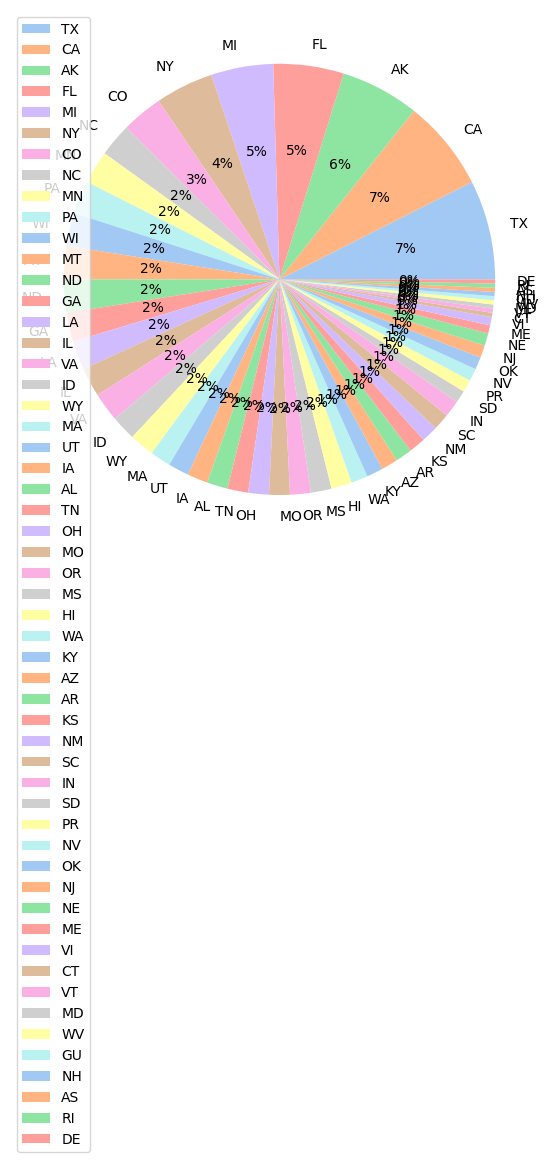

In [13]:
# Plot this as a pie chart
import matplotlib.pyplot as plt
import seaborn

palette_color = seaborn.color_palette('pastel')

plt.figure(figsize = (7, 7))
plt.pie(df_airports_state['COUNT'],
        labels = df_airports_state['STATE'],
        colors = palette_color,
        autopct = '%.0f%%',)

plt.legend(df_airports_state['STATE'], loc = "best")

In [14]:
df_airports_state = conn.execute('''
  SELECT
    STATE,
    count(*) as COUNT
  FROM airports
  GROUP BY STATE
  ORDER BY Count DESC
  LIMIT 10
''').df()
df_airports_state.head()

,STATE,COUNT
0,TX,24
1,CA,22
2,AK,19
3,FL,17
4,MI,15


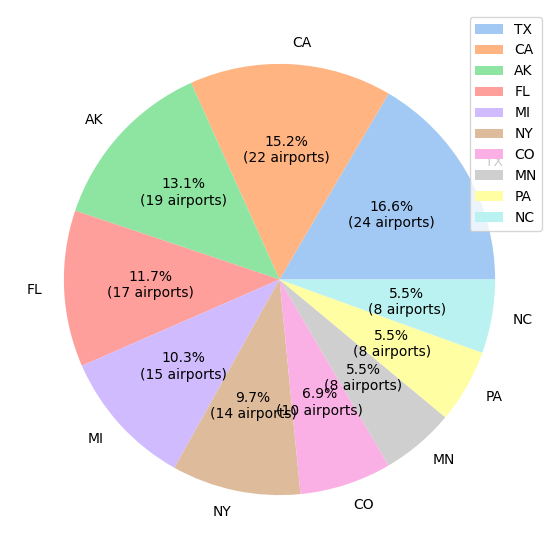

In [15]:
# total number of airports
total = df_airports_state['COUNT'].sum()

def fmt(x):
    return '{:.1f}%\n({:.0f} airports)'.format(x, total * x / 100)

palette_color = seaborn.color_palette('pastel')

plt.figure(figsize = (7, 7))
plt.pie(df_airports_state['COUNT'],
        labels = df_airports_state['STATE'],
        colors = palette_color,
        autopct = fmt)

plt.legend(df_airports_state['STATE'], loc = "best")

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'TX'),
  Text(1, 0, 'CA'),
  Text(2, 0, 'AK'),
  Text(3, 0, 'FL'),
  Text(4, 0, 'MI'),
  Text(5, 0, 'NY'),
  Text(6, 0, 'CO'),
  Text(7, 0, 'MN'),
  Text(8, 0, 'PA'),
  Text(9, 0, 'NC')])

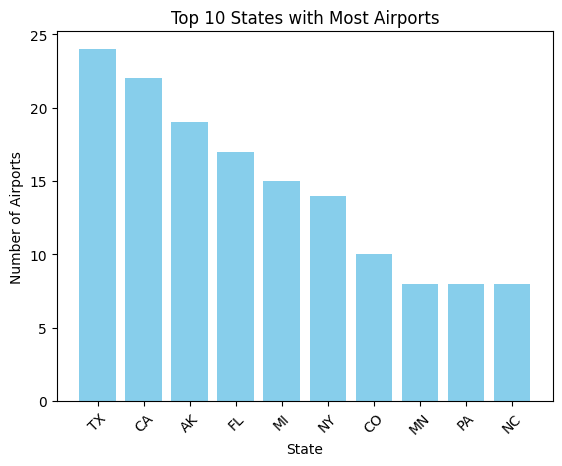

In [16]:
# create the bar chart
plt.bar(df_airports_state['STATE'],
        df_airports_state['COUNT'],
        color='skyblue')

plt.xlabel('State')
plt.ylabel('Number of Airports')
plt.title('Top 10 States with Most Airports')
plt.xticks(rotation = 45)

### Obtaining the Flight Counts for Each Pair of Origin and Destination Airports

In [17]:
conn.execute('''
  SELECT
    ORIGIN_AIRPORT, COUNT(ORIGIN_AIRPORT) as COUNT
  FROM flights
  GROUP BY ORIGIN_AIRPORT
  ORDER BY COUNT DESC
''').df()

,ORIGIN_AIRPORT,COUNT
0,ATL,346836
1,ORD,285884
2,DFW,239551
3,DEN,196055
4,LAX,194673
...,...,...
623,13541,11
624,10165,9
625,14222,9
626,13502,6


In [18]:
conn.execute('''
  SELECT
    ORIGIN_AIRPORT, DESTINATION_AIRPORT,
    COUNT(*) as COUNT
  FROM flights
  GROUP BY ORIGIN_AIRPORT, DESTINATION_AIRPORT
  ORDER BY COUNT DESC
''').df()

,ORIGIN_AIRPORT,DESTINATION_AIRPORT,COUNT
0,SFO,LAX,13744
1,LAX,SFO,13457
2,JFK,LAX,12016
3,LAX,JFK,12015
4,LAS,LAX,9715
...,...,...,...
8604,EUG,BOI,1
8605,GCC,RAP,1
8606,TPA,SFO,1
8607,LGA,DSM,1


In [19]:
conn.execute('''
  SELECT
    ORIGIN_AIRPORT, DESTINATION_AIRPORT,
    COUNT(*) as COUNT
  FROM flights
  WHERE AIRLINE='DL'
  GROUP BY ORIGIN_AIRPORT, DESTINATION_AIRPORT
  ORDER BY COUNT DESC
''').df()

,ORIGIN_AIRPORT,DESTINATION_AIRPORT,COUNT
0,LGA,ATL,5303
1,ATL,LGA,5298
2,MCO,ATL,5250
3,ATL,MCO,5247
4,FLL,ATL,4780
...,...,...,...
1659,DFW,MSN,1
1660,PIT,LGA,1
1661,10792,13487,1
1662,SEA,SMF,1


### Getting the Canceled Flights from Airlines

In [20]:
conn.execute('''
  SELECT
    ORIGIN_AIRPORT, DESTINATION_AIRPORT,
    COUNT(*) as COUNT
  FROM flights
  WHERE AIRLINE='DL' AND CANCELLED = 1
  GROUP BY ORIGIN_AIRPORT, DESTINATION_AIRPORT
  ORDER BY COUNT DESC
'''
).df()

,ORIGIN_AIRPORT,DESTINATION_AIRPORT,COUNT
0,LGA,BOS,146
1,BOS,LGA,146
2,LGA,ATL,87
3,ATL,LGA,78
4,BOS,ATL,58
...,...,...,...
454,10423,10397,1
455,LAX,SJC,1
456,SLC,STL,1
457,MSP,FAR,1


In [21]:
conn.execute('''
  SELECT
    ORIGIN_AIRPORT, DESTINATION_AIRPORT,
    (SUM(CANCELLED) * 100.0) / COUNT(*) as CANCELLED_PERCENT
  FROM flights
  WHERE AIRLINE = 'DL'
  GROUP BY ORIGIN_AIRPORT, DESTINATION_AIRPORT
  ORDER BY CANCELLED_PERCENT DESC
'''
).df()

,ORIGIN_AIRPORT,DESTINATION_AIRPORT,CANCELLED_PERCENT
0,BOS,LGA,4.500617
1,LGA,BOS,4.490926
2,LGA,SRQ,4.040404
3,SRQ,LGA,4.040404
4,RSW,JFK,3.636364
...,...,...,...
1659,13487,12945,0.000000
1660,12173,13487,0.000000
1661,14747,14771,0.000000
1662,MIA,SLC,0.000000


In [22]:
conn.execute('''
  SELECT
    (SUM(CANCELLED) * 100.0) / COUNT(*) as CANCELLED_PERCENT
  FROM flights
  WHERE AIRLINE = 'DL'
'''
).df()

,CANCELLED_PERCENT
0,0.436589


In [23]:
import matplotlib.pyplot as plt
df = conn.execute('''
  SELECT AIRLINE,
    (SUM(CANCELLED) * 100.0) / COUNT(*) as CANCELLED_PERCENT
  FROM flights
     -- WHERE AIRLINE = 'DL'
  GROUP BY AIRLINE
  ORDER BY CANCELLED_PERCENT DESC
'''
).df()
display(df)

,AIRLINE,CANCELLED_PERCENT
0,MQ,5.099582
1,EV,2.662869
2,US,2.046650
3,NK,1.707290
4,OO,1.692861
5,B6,1.601210
6,AA,1.504028
7,UA,1.274521
8,WN,1.271382
9,VX,0.862640


Text(0.5, 1.0, 'Cancellation Percentage for Different Airlines')

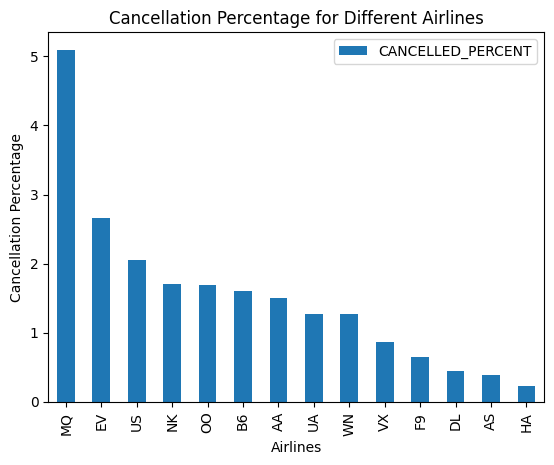

In [24]:
df.plot(kind='bar', x='AIRLINE', y='CANCELLED_PERCENT')

plt.xlabel('Airlines')
plt.ylabel('Cancellation Percentage')
plt.title('Cancellation Percentage for Different Airlines')

Text(0.5, 1.0, 'Cancellation Percentage for Different Airlines')

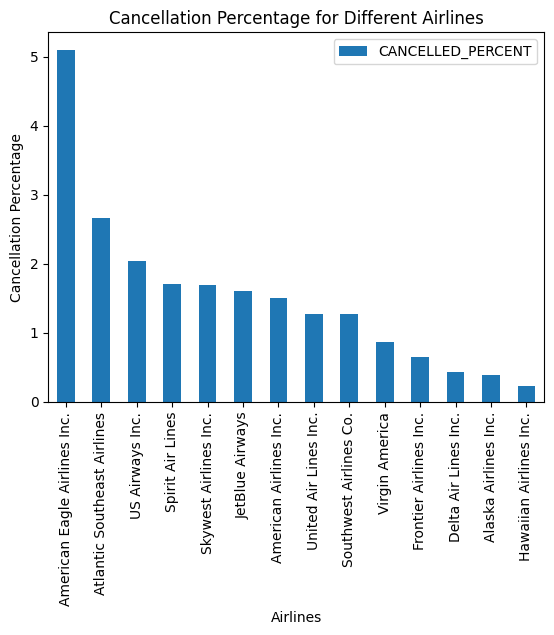

In [25]:
import matplotlib.pyplot as plt
df = conn.execute('''
  SELECT
    a.AIRLINE,
    (SUM(f.CANCELLED) * 100.0) / COUNT(*) as CANCELLED_PERCENT
  FROM flights f
  JOIN airlines a ON f.AIRLINE = a.IATA_CODE
  GROUP BY a.AIRLINE
  ORDER BY CANCELLED_PERCENT DESC
'''
).df()
df.plot(kind='bar', x='AIRLINE', y='CANCELLED_PERCENT')
plt.xlabel('Airlines')
plt.ylabel('Cancellation Percentage')
plt.title('Cancellation Percentage for Different Airlines')

Text(0.5, 1.0, 'Cancellation Percentage for Different Airlines')

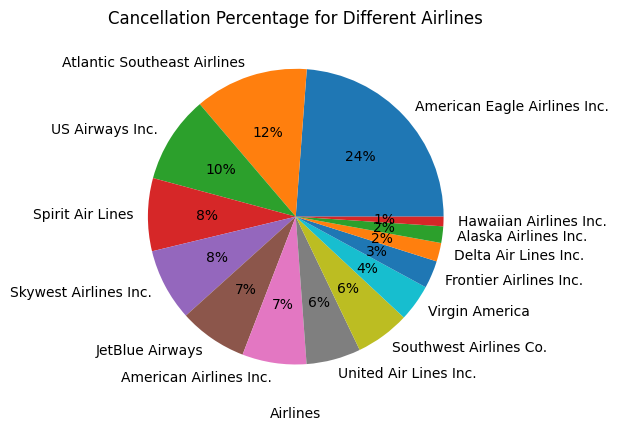

In [26]:
ax = df.plot(kind='pie',
             x='AIRLINE',
             y='CANCELLED_PERCENT',
             labels = df['AIRLINE'],
             autopct = '%.0f%%',
             legend=False
)
ax.get_yaxis().set_visible(False)
plt.xlabel('Airlines')
plt.title('Cancellation Percentage for Different Airlines')

### Getting the Flight Count for Each Day of the Week

In [27]:
df_flights_day_of_week = conn.execute('''
  SELECT
    day_of_week,
    origin_airport,
    destination_airport,
    COUNT(*) AS flight_count
  FROM
    flights
  WHERE
    CANCELLED = 0 -- Exclude cancelled flights
  GROUP BY
    day_of_week,
    origin_airport,
    destination_airport
  ORDER BY
    day_of_week,
    origin_airport,
    destination_airport;
''').df()
df_flights_day_of_week

,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT,flight_count
0,1,10135,10397,12
1,1,10135,11433,12
2,1,10135,13930,11
3,1,10136,11298,28
4,1,10140,10397,12
...,...,...,...,...
57262,7,XNA,ORD,271
57263,7,XNA,SFO,8
57264,7,YAK,CDV,47
57265,7,YAK,JNU,48


### Verifying Airport Codes

In [28]:
conn.execute('''
  SELECT 
    YEAR, MONTH, DAY, ORIGIN_AIRPORT, DESTINATION_AIRPORT
  FROM flights
  WHERE ORIGIN_AIRPORT NOT SIMILAR TO '[A-Za-z]+'
  OR DESTINATION_AIRPORT NOT SIMILAR TO '[A-Za-z]+';
''').df()

,YEAR,MONTH,DAY,ORIGIN_AIRPORT,DESTINATION_AIRPORT
0,2015,10,1,14747,11298
1,2015,10,1,14771,13487
2,2015,10,1,12889,13487
3,2015,10,1,12892,13303
4,2015,10,1,14771,11057
...,...,...,...,...,...
486160,2015,10,31,11292,12478
486161,2015,10,31,12478,10732
486162,2015,10,31,12478,14843
486163,2015,10,31,14747,12266


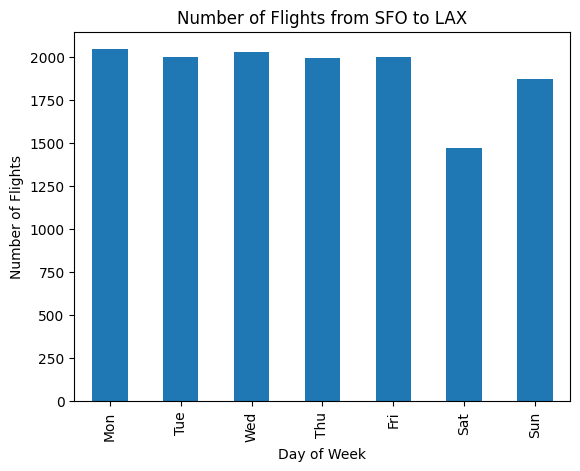

In [29]:
from_airport = 'SFO'
to_airport = 'LAX'

df_flights_result = df_flights_day_of_week.query(
    f'ORIGIN_AIRPORT=="{from_airport}" & DESTINATION_AIRPORT=="{to_airport}"')
df_flights_result.plot(kind='bar',
                       x = 'DAY_OF_WEEK',
                       y = 'flight_count',
                       legend = False)

plt.xlabel('Day of Week')
plt.ylabel('Number of Flights')
plt.title(f'Number of Flights from {from_airport} to {to_airport}')

plt.xticks(df_flights_result['DAY_OF_WEEK'] - 1,
           ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

#### Calculating the percentages of flights on each weekday for given origin and destination airports, excluding canceled flights.

In [30]:
df_flights_weekday = conn.execute('''
with t1 as (
  SELECT
    day_of_week,
    origin_airport,
    destination_airport,
    COUNT(*) AS flight_count_per_weekday
  FROM
    flights
  WHERE
    CANCELLED = 0 -- Exclude cancelled flights
  GROUP BY
    day_of_week,
    origin_airport,
    destination_airport
  ORDER BY
    day_of_week,
    origin_airport,
  destination_airport
),
t2 as (
  SELECT
    origin_airport,
    destination_airport,
    count(*) as total_flight_count
  FROM
    flights
  WHERE
    CANCELLED = 0 -- Exclude cancelled flights
  GROUP BY
    origin_airport,
    destination_airport
)
SELECT
  t1.origin_airport,
  t1.destination_airport,
  t1.day_of_week,
  t2.total_flight_count,
  100. * (t1.flight_count_per_weekday / t2.total_flight_count) as
  percent_flights_on_weekday
FROM t1
JOIN t2
ON
  t1.origin_airport = t2.origin_airport AND
  t1.destination_airport = t2.destination_airport
''').df()
df_flights_weekday

,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DAY_OF_WEEK,total_flight_count,percent_flights_on_weekday
0,BTR,ATL,4,2487,14.716526
1,BTR,DFW,4,2241,14.591700
2,BTR,IAH,4,2274,15.303430
3,BTV,ATL,4,298,14.093960
4,BTV,DTW,4,516,15.503876
...,...,...,...,...,...
57262,BRO,DFW,4,1004,14.641434
57263,BRO,IAH,4,1261,15.146709
57264,BRW,ANC,4,323,13.622291
57265,BRW,FAI,4,322,14.285714


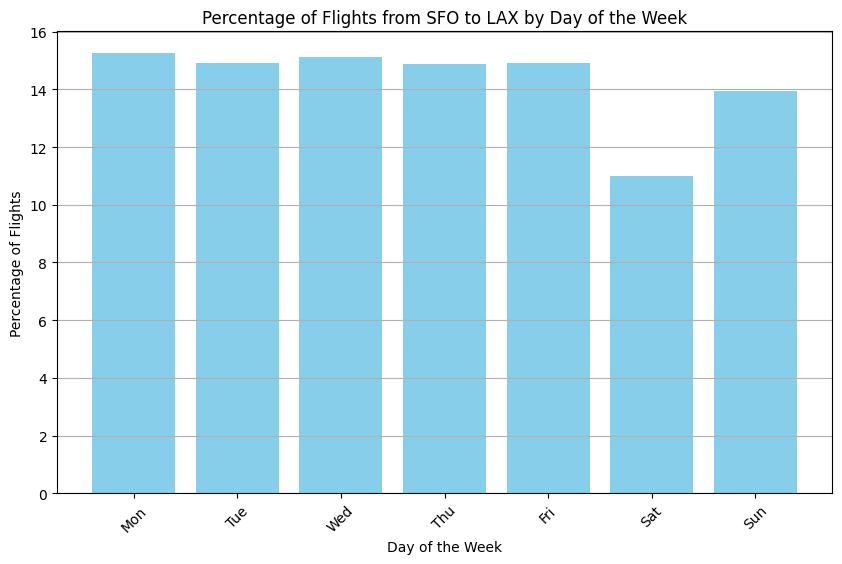

In [31]:
from_airport = 'SFO'
to_airport = 'LAX'

# step 1: Filter the DataFrame for SFO to LAX
sfo_to_las_flights = df_flights_weekday.query(
f'ORIGIN_AIRPORT=="{from_airport}" & DESTINATION_AIRPORT=="{to_airport}"')

# step 2: Plotting
plt.figure(figsize=(10, 6))
plt.bar(sfo_to_las_flights['DAY_OF_WEEK'],
        sfo_to_las_flights['percent_flights_on_weekday'],
        color='skyblue')

plt.xticks(sfo_to_las_flights['DAY_OF_WEEK'].sort_values(),
           ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title(f'Percentage of Flights from {from_airport} ' + 
          f'to {to_airport} by Day of the Week')

plt.xlabel('Day of the Week')
plt.ylabel('Percentage of Flights')
plt.xticks(rotation=45)
plt.grid(axis='y')

### Finding the Most Common Timeslot for Flight Delays

In [32]:
df_delays_by_week = conn.execute('''
SELECT
  DAY_OF_WEEK,
CASE
  WHEN SCHEDULED_DEPARTURE BETWEEN '0000' AND '0559' THEN '00:00-06:00'
  WHEN SCHEDULED_DEPARTURE BETWEEN '0600' AND '1159' THEN '06:00-12:00'
  WHEN SCHEDULED_DEPARTURE BETWEEN '1200' AND '1759' THEN '12:00-18:00'
  WHEN SCHEDULED_DEPARTURE BETWEEN '1800' AND '2400' THEN '18:00-24:00'
ELSE 'Other'
  END AS DEPARTURE_TIME_INTERVAL,
  AVG(ARRIVAL_DELAY) AS AVG_ARRIVAL_DELAY
FROM
  flights
WHERE
  ARRIVAL_DELAY > 0
GROUP BY
  DAY_OF_WEEK,
CASE
  WHEN SCHEDULED_DEPARTURE BETWEEN '0000' AND '0559' THEN '00:00-06:00'
  WHEN SCHEDULED_DEPARTURE BETWEEN '0600' AND '1159' THEN '06:00-12:00'
  WHEN SCHEDULED_DEPARTURE BETWEEN '1200' AND '1759' THEN '12:00-18:00'
  WHEN SCHEDULED_DEPARTURE BETWEEN '1800' AND '2400' THEN '18:00-24:00'
ELSE 'Other'
END
ORDER BY
  DAY_OF_WEEK, DEPARTURE_TIME_INTERVAL;
''').df()
df_delays_by_week
# Divide the day into four intervals based on scheduled departure times
# 12 a.m to 06 a.m.
# 06 a.m to 12 p.m.
# 12 p.m. to 06 p.m.
# 06 p.m. to 12 a.m.

,DAY_OF_WEEK,DEPARTURE_TIME_INTERVAL,AVG_ARRIVAL_DELAY
0,1,00:00-06:00,32.348575
1,1,06:00-12:00,31.576553
2,1,12:00-18:00,37.778949
3,1,18:00-24:00,39.396041
4,2,00:00-06:00,30.334905
5,2,06:00-12:00,29.191015
6,2,12:00-18:00,35.259384
7,2,18:00-24:00,37.801541
8,3,00:00-06:00,29.617457
9,3,06:00-12:00,28.237131


In [33]:
df_delays_by_week_pivot = df_delays_by_week.pivot(
index = 'DAY_OF_WEEK',
columns = 'DEPARTURE_TIME_INTERVAL',
values = 'AVG_ARRIVAL_DELAY')
df_delays_by_week_pivot

DEPARTURE_TIME_INTERVAL,00:00-06:00,06:00-12:00,12:00-18:00,18:00-24:00
DAY_OF_WEEK,,,,
1,32.348575,31.576553,37.778949,39.396041
2,30.334905,29.191015,35.259384,37.801541
3,29.617457,28.237131,33.427170,34.349877
4,25.404742,27.648437,34.133880,36.982575
5,26.451996,26.634905,32.529718,35.998932
6,30.042233,27.598548,33.975286,36.418688
7,29.783261,29.875063,34.226615,36.372640


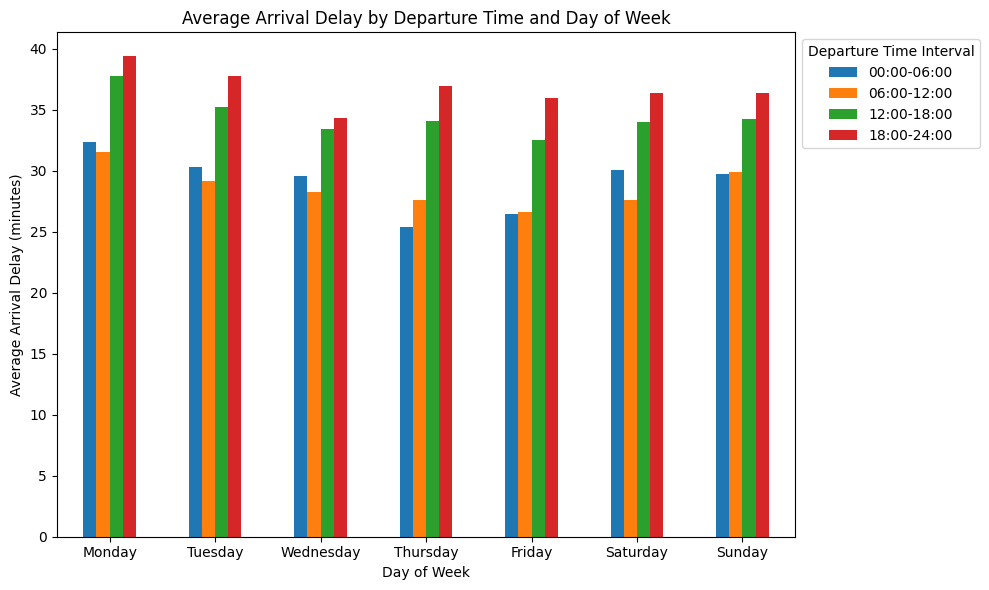

In [34]:
# plotting a bar chart
df_delays_by_week_pivot.plot(kind='bar',
                             stacked=False,
figsize=(10, 6))

# updating the x-ticks to show the days of the week
days_of_week = ['Monday', 'Tuesday', 'Wednesday',
                'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.xticks(ticks=range(len(days_of_week)), labels=days_of_week, rotation=0)
plt.title('Average Arrival Delay by Departure Time and Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Arrival Delay (minutes)')
plt.legend(title='Departure Time Interval', bbox_to_anchor=(1, 1))
plt.tight_layout() # Adjust layout to avoid clipping of labels
plt.show()

### Finding the Airlines with the Most and Fewest Delays

In [35]:
df_most_delays = conn.execute('''
  SELECT
    count(airlines.AIRLINE) as Count,
    airlines.AIRLINE
  FROM flights, airlines
  WHERE airlines.IATA_CODE = flights.AIRLINE AND flights.ARRIVAL_DELAY > 0
  GROUP BY airlines.AIRLINE
  ORDER BY COUNT DESC
''').df()
df_most_delays

,Count,AIRLINE
0,470767,Southwest Airlines Co.
1,252191,American Airlines Inc.
2,250840,Delta Air Lines Inc.
3,222435,Skywest Airlines Inc.
4,213217,Atlantic Southeast Airlines
5,186227,United Air Lines Inc.
6,103505,American Eagle Airlines Inc.
7,101998,JetBlue Airways
8,76285,US Airways Inc.
9,56953,Alaska Airlines Inc.


In [36]:
df_percent_delay = conn.execute('''
WITH flight_delays AS (
  SELECT
  AIRLINE,
  1.0 * count(*) as TotalFlights,
  1.0 * sum(case when ARRIVAL_DELAY > 0 then 1 else 0 end) as Delays,
  (1.0 * sum(case when ARRIVAL_DELAY > 0 then 1 else 0 end) /
  count(*)) * 100 as Percentage
FROM flights
GROUP BY AIRLINE
)
SELECT
  flight_delays.Percentage,
  airlines.IATA_CODE,
  airlines.AIRLINE
FROM flight_delays
  JOIN airlines ON airlines.IATA_CODE = flight_delays.AIRLINE
ORDER BY flight_delays.Percentage DESC;
''').df()

In [37]:
df_percent_delay

,Percentage,IATA_CODE,AIRLINE
0,48.464376,NK,Spirit Air Lines
1,45.391695,F9,Frontier Airlines Inc.
2,39.567600,HA,Hawaiian Airlines Inc.
3,39.061112,VX,Virgin America
4,38.389150,US,US Airways Inc.
5,38.194632,B6,JetBlue Airways
6,37.806385,OO,Skywest Airlines Inc.
7,37.307535,WN,Southwest Airlines Co.
8,37.277198,EV,Atlantic Southeast Airlines
9,36.109888,UA,United Air Lines Inc.


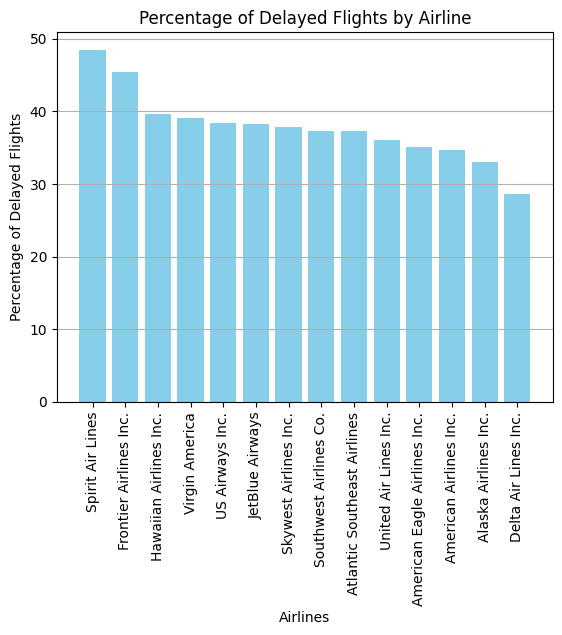

In [38]:
plt.bar(df_percent_delay['AIRLINE'],
df_percent_delay['Percentage'],
        color='skyblue')

plt.title('Percentage of Delayed Flights by Airline')
plt.xlabel('Airlines')
plt.ylabel('Percentage of Delayed Flights')
plt.xticks(rotation = 90)
plt.grid(axis='y')

In [39]:
df_percent_on_time = conn.execute('''
WITH flight_delays AS (
  SELECT
    AIRLINE,
    1.0 * count(*) as TotalFlights,
    1.0 * sum(case when ARRIVAL_DELAY <= 0 then 1 else 0 end) as
    OnTimeFlights,
    (1.0 * sum(case when ARRIVAL_DELAY <= 0 then 1 else 0 end) /
    count(*)) * 100 as Percentage
  FROM flights
  GROUP BY AIRLINE
)
SELECT
  flight_delays.Percentage,
  airlines.IATA_CODE,
  airlines.AIRLINE
FROM flight_delays
JOIN airlines ON airlines.IATA_CODE = flight_delays.AIRLINE
ORDER BY flight_delays.Percentage DESC;
''').df()
df_percent_on_time

,Percentage,IATA_CODE,AIRLINE
0,70.721365,DL,Delta Air Lines Inc.
1,66.360617,AS,Alaska Airlines Inc.
2,63.464760,AA,American Airlines Inc.
3,62.346453,UA,United Air Lines Inc.
4,61.150925,WN,Southwest Airlines Co.
5,60.232378,OO,Skywest Airlines Inc.
6,60.129536,HA,Hawaiian Airlines Inc.
7,59.930799,B6,JetBlue Airways
8,59.880781,VX,Virgin America
9,59.711317,EV,Atlantic Southeast Airlines


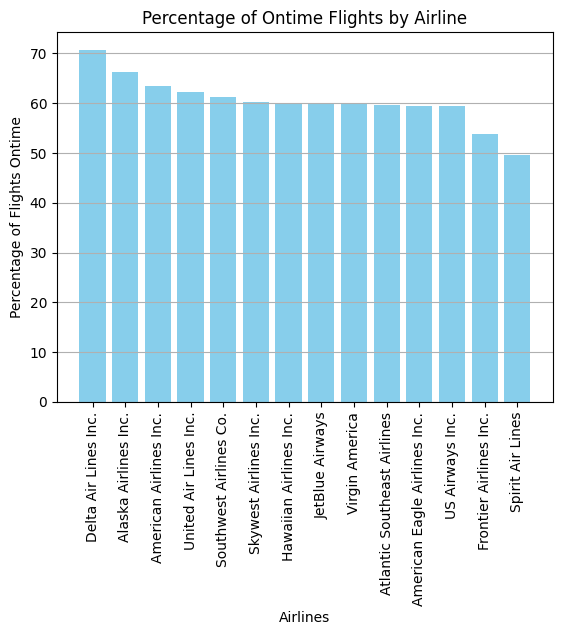

In [40]:
plt.bar(df_percent_on_time['AIRLINE'],
df_percent_on_time['Percentage'],
        color='skyblue')

plt.title('Percentage of Ontime Flights by Airline')
plt.xlabel('Airlines')
plt.ylabel('Percentage of Flights Ontime')
plt.xticks(rotation = 90)
plt.grid(axis='y')